# Advanced Lane Line Detection

--- 

## Project Goals

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import imageio
imageio.plugins.ffmpeg.download()
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration With OpenCV

---

Later on in this project, I will be preforming a perspective transfom on input images. For this to work properly I need the input image to be flat. This means that I have to account for and correct the distortion that a camera lense causes.

Calibration works by taking pictures of known shapes, and calculating how they have been distorted. Typically this is achived by taking a picture of a checkerboard pattern, calculating the coordinates of the corners touching black and white tiles (inside corners), and then calculating the distortion needed to make the points on each row and column fall on a straight line.

Since camera lenses are rigid and don't change, we can take calibration images for a camera and then used the calculated calibration in any setting.

In [165]:
def load_calibration_points(calibration_directory = "camera_cal/",file_names = "calibration*.jpg",nx = 9, ny = 6):
    images = glob.glob(calibration_directory+file_names)

    image_points = []
    object_points = []

    static_object_points = np.zeros((nx*ny,3),np.float32)
    static_object_points[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for fname in images:

        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

        if ret == True:
            image_points.append(corners)
            object_points.append(static_object_points)
            
            img = cv2.drawChessboardCorners(img,(8,6),corners,ret)
    
    return image_points,object_points
        



    
def calc_lens_distortion(shape = (720,1280)):
    
    image_points,object_points = load_calibration_points()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, shape, None, None)
    
    return mtx,dist

            
    
mtx,dist = calc_lens_distortion()      
        
def undistort_img(img,mxt = mtx,dist = dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

    


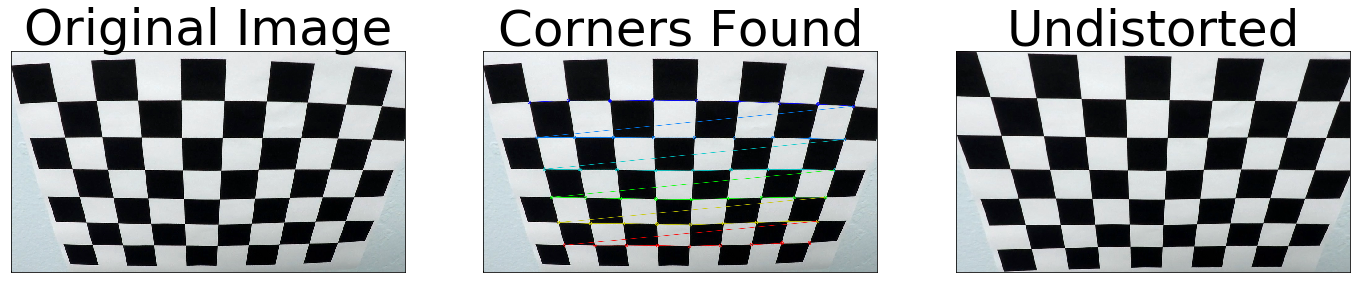

In [168]:
def show_example_calibration(img):
    # Get Corners
    nx = 9
    ny = 6
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    corner_img = img.copy()
    cv2.drawChessboardCorners(corner_img, (nx, ny), corners, ret)
    
    # Get Undistorted Image
    undst = undistort_img(img.copy())#,image_points,object_points)
    
    
    #Plot Images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    ax1.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    
    ax2.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax2.imshow(corner_img)
    ax2.set_title('Corners Found', fontsize=50)
    
    ax3.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax3.imshow(undst)
    ax3.set_title('Undistorted', fontsize=50)
    
sample_image = cv2.imread("camera_cal/"+"calibration2.jpg")   
show_example_calibration(sample_image)



## Using New Color Spaces with OpenCV

---

Images are typcailly stored and displayed with the RGB color space, but RGB isn't the best color space for every use case. Later in this project I will be applying a gradient filter to the image to detect lane lines. For best results, the gradient filter needs a lot of contrast betweent the road and the lane lines. 

RGB works well when the road is black and the lane lines are white, but not so well with shadows, yellow lines, and gray pavement. A better color space for detecting lane lines is HLS, or hue, saturation, lightness. The lightness aspect is just the grayscale version of image, which has an extreme version of the pitfalls of the RGB color space, so we typically ignore that for lane line detection. Hue and saturation could both be used, but saturation is a bit cleaner so I will be using saturation for this project.



0


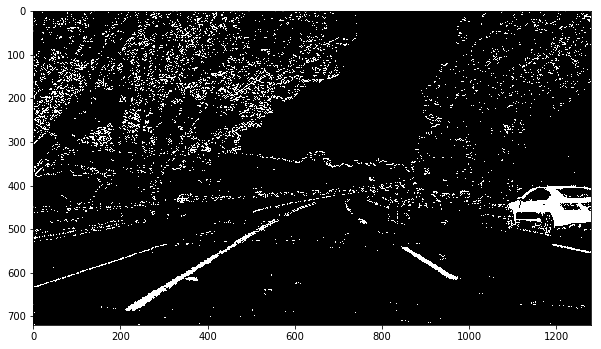

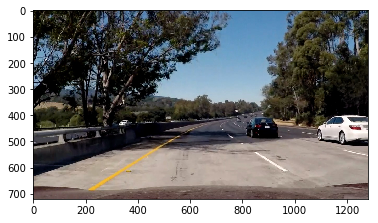

In [439]:

sample_road = cv2.imread("test_images/test5.jpg")

HSV = cv2.cvtColor(sample_road, cv2.COLOR_BGR2HSV)
HSL = cv2.cvtColor(sample_road, cv2.COLOR_RGB2HLS)

yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))


white_lo = 200
white = cv2.inRange(sample_road, (lo,lo,lo), (255,255,255))


color_mask = []
for i in range(3):
    mask.append(sobel_threshold(sample_road[:,:,i]))
    


gray_sobel = sobel_threshold(cv2.cvtColor(sample_road,cv2.COLOR_BGR2GRAY),(1,1),(2,2))

bit_layer = np.zeros_like(HSV[:,:,1])
bit_layer[(mask[0] > 0) | (mask[1] > 0) | (mask[2] > 0) | (yellow > 0) | (white > 0)] = 1
plt.figure(figsize=(10,20))
plt.imshow(bit_layer,cmap = 'gray')
plt.show()
"""
bit_layer =  mask[0] 
plt.figure(figsize=(10,20))
plt.imshow(bit_layer,cmap = 'gray')
plt.show()
bit_layer =  mask[1] 
plt.figure(figsize=(10,20))
plt.imshow(bit_layer,cmap = 'gray')
plt.show()
bit_layer =  mask[2]
plt.figure(figsize=(10,20))
plt.imshow(bit_layer,cmap = 'gray')
plt.show()
"""


plt.imshow(cv2.cvtColor(sample_road,cv2.COLOR_BGR2RGB))
plt.show()

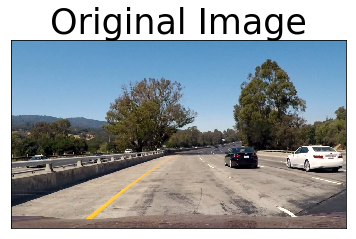

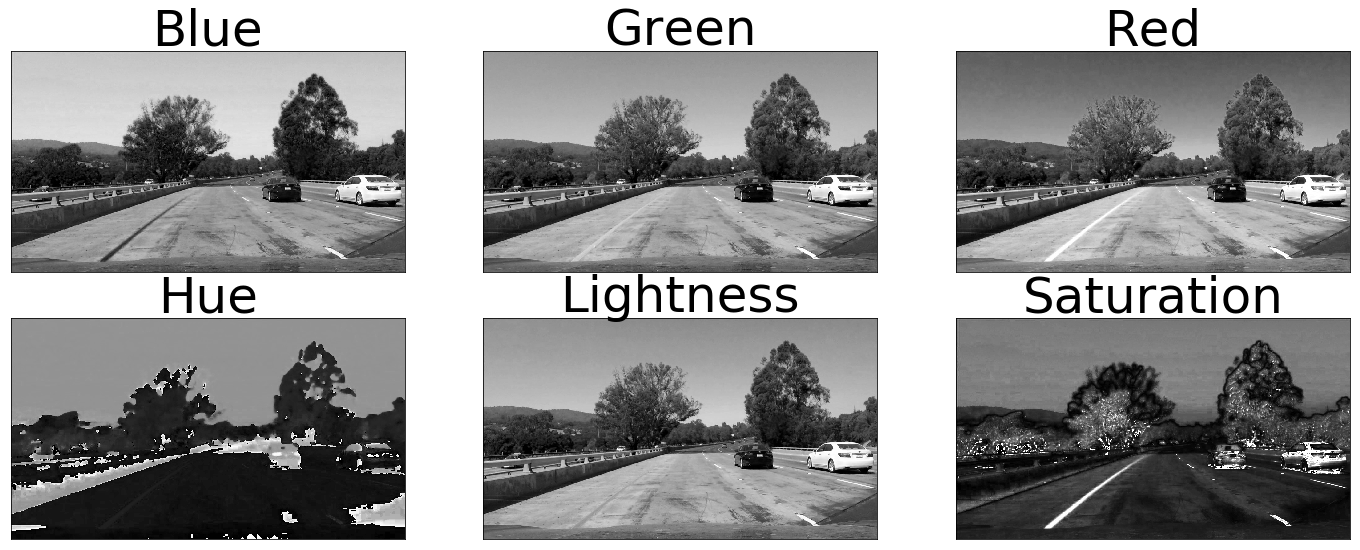

In [296]:
def show_example_hls(img):
    plt.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title('Original Image', fontsize = 35)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    #plt.imshow(H, cmap = 'gray')
    
    
    #Plot Images
    f, (ax1, ax2) = plt.subplots(2, 3, figsize=(24, 9))    
    bgr_label = ['Blue','Green','Red']
    hls_label = ['Hue','Lightness','Saturation']
    
    for i in range(3):
        ax1[i].tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        ax1[i].imshow(img[:,:,i],cmap = 'gray')
        ax1[i].set_title(bgr_label[i],fontsize=50)
        
        ax2[i].tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        ax2[i].imshow(hls[:,:,i], cmap = 'gray')
        ax2[i].set_title(hls_label[i],fontsize=50)

    
sample_road = cv2.imread("test_images/test1.jpg")
show_example_hls(sample_road)
    

    

## Detecting Gradients using the Sobel Opperatior with OpenCV

---

Looking at the saturation image we can see that the lane lines are fairly clear, but there is still noise. For example, the color of the lane is slightly distorted in the middle. The next step is to use gradient thresholding to hone in on the lane lines. To do this, we have to calculate the vertical gradient, and horiziontal gradient.

Once we have both gradeints we can calculate the angle of the gradient and ignore any gradient that isn't steep, as we expect lane lines to be close to vertical. This will be done by applying the x and y sobel opperator to the image. Below is an image of the x and y sobel opperator.

<img src="markdown_images/sobel.png">

These opperators are used to estimate the derivative, effectively measuring the steepness of the gradient at every point on the image. This is done by multiplying every 3x3 set of pixels (overlapping) on a one channel image (ie Saturation) and then summing up all the values. From there we can apply a threshold for the intensity of the gradient as well as the angle of the gradient.  


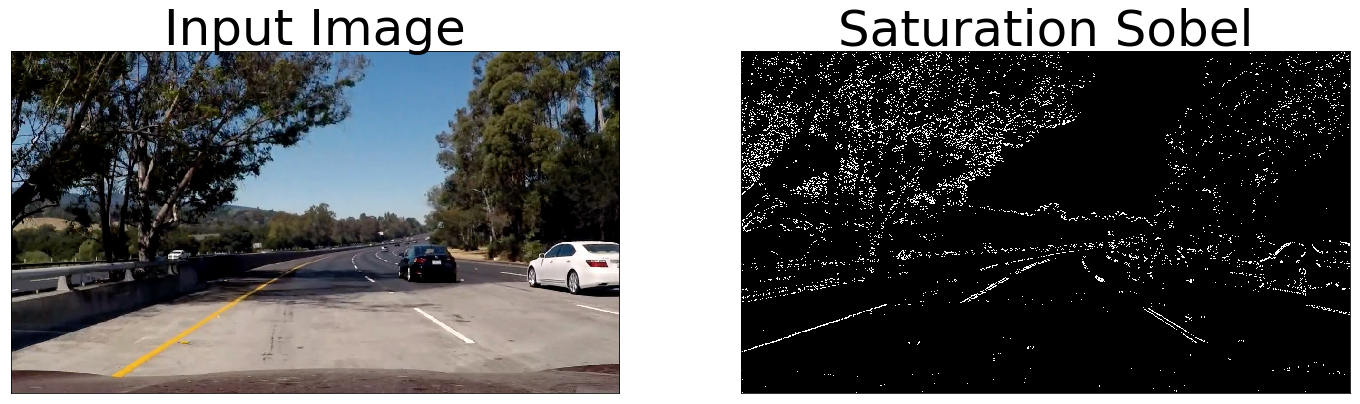

In [15]:
# Return a thresholded image using sobel magnitude and angle
def sobel_threshold(img, mag_thresh=(0, 255),ang_thresh=(0, np.pi/2)):
    
    # Apply x and y gradient with the OpenCV Sobel() function and take abs value
    x_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    y_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    
    # Get get absolute value of direction of gradient
    grad_ang = np.arctan2(y_sobel, x_sobel)
    
    # Get magnitude of direction of gradient
    grad_mag = np.sqrt(y_sobel**2 + x_sobel**2)
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    
    
    
    # Create a copy of sobel
    # Sobel is 1 px smaller on all sides so img will not work here
    binary_output = np.zeros_like(x_sobel).astype(np.uint8)
    
    # Apply Gradient
    #binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1]) &
    #            (abs_grad_dir >= ang_thresh[0]) & (abs_grad_dir <= ang_thresh[1])] = 1
    binary_output[(grad_mag > 35) & (grad_ang > .6) & (grad_ang < 1.4)] = 255

    return binary_output


def show_example_sobel(img,mag_thresh,ang_thresh):
    
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS).astype(np.float)
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    saturation_sobel_img = sobel_threshold(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),mag_thresh,ang_thresh)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))    
    ax1.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax1.imshow(rgb)
    ax1.set_title('Input Image',fontsize=50)
        
    ax2.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax2.imshow(saturation_sobel_img, cmap = 'gray')
    ax2.set_title("Saturation Sobel",fontsize=50)


sample_road = cv2.imread("test_images/test5.jpg")
mag_thresh = (30, 100)
ang_thresh = (0.6, 1.4)
show_example_sobel(sample_road,mag_thresh,ang_thresh)

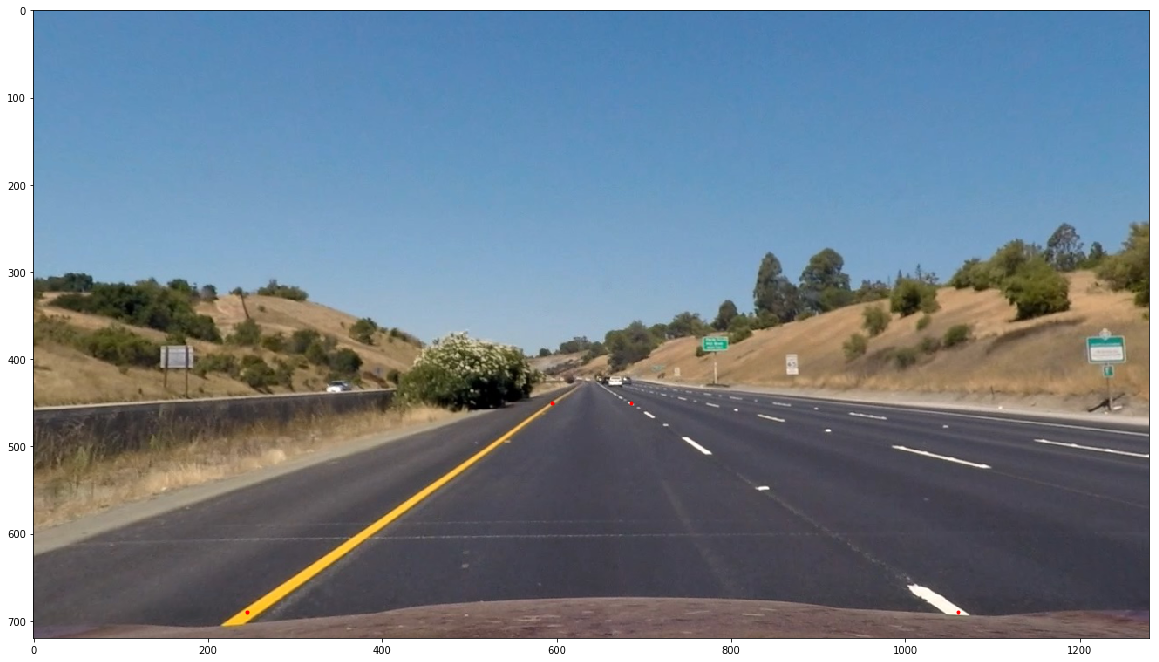

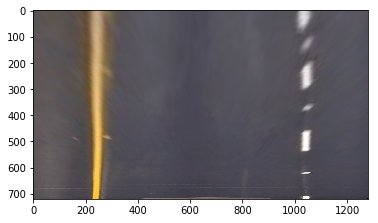

In [187]:
flat_road = cv2.imread("test_images/straight_lines1.jpg")
rgb = cv2.cvtColor(flat_road,cv2.COLOR_BGR2RGB)
undst = undistort_img(rgb)#,image_points,object_points)
plt.figure(figsize=(20,30))

src = np.float32([[245,690],[1060,690],[685,450],[595,450]])

margin = 235
dst = np.float32([[margin,720],[1280-margin,720],[1280-margin,0],[margin,0]])

M = cv2.getPerspectiveTransform(src, dst)
rgb_warped = cv2.warpPerspective(undst, M, (1280,720), flags=cv2.INTER_LINEAR)

plt.imshow(undst)
for point in src:
    plt.plot(point[0],point[1],'.',color = 'red')
plt.show()

plt.imshow(rgb_warped)
plt.show()

(720, 1280, 3)


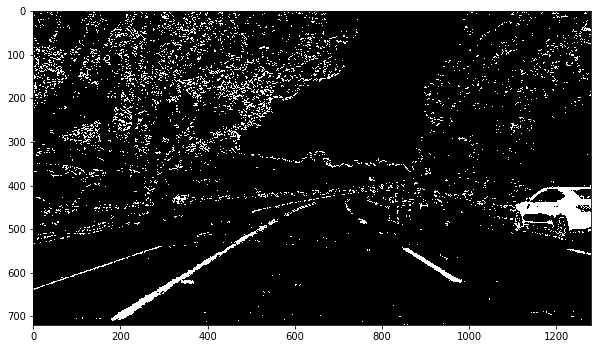

(720, 1280)


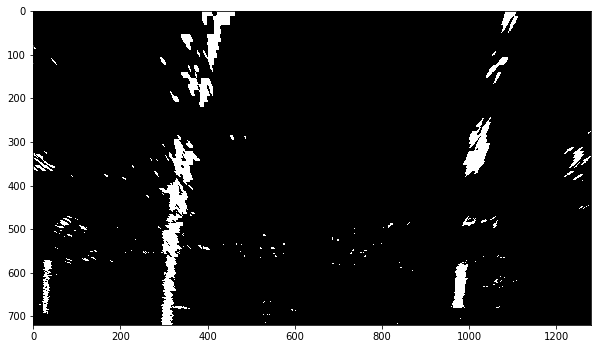

In [504]:




pts = src.reshape((-1,1,2)).astype(int)
#cv2.polylines(rgb,[pts],True,(0,255,0), thickness = 3)
plt.imshow(bit,cmap = 'gray')
plt.show()

M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(bit, M, (1280,720), flags=cv2.INTER_LINEAR)
Minv = cv2.getPerspectiveTransform(dst,src)
binary_warped = cv2.warpPerspective(bit, M, (1280,720), flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,20))
plt.imshow(binary_warped,cmap = 'gray')

binary_warped = binary_warped[:,:,None]

In [473]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 70
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

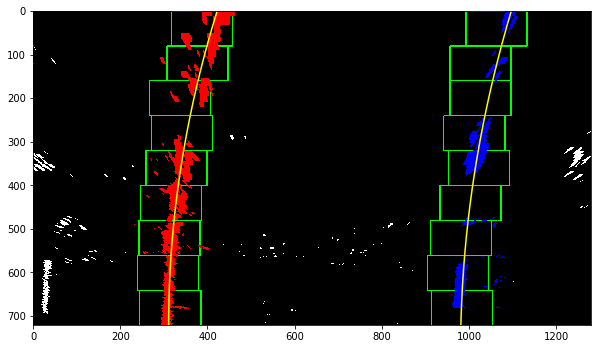

In [480]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(10,20))

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [507]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 75
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

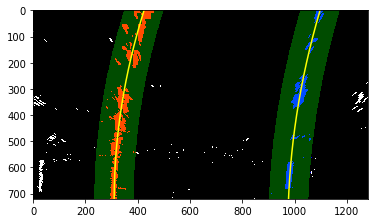

In [508]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [498]:
ym_per_pix = 24/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
y_eval = binary_warped.shape[0]
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


(720,) (20145,) (8947,)
490.961418017 m 553.007763374 m


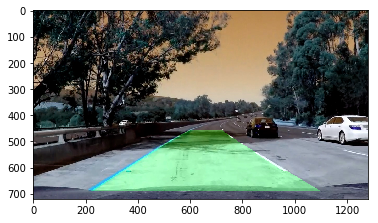

In [505]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
ploty = np.linspace(0, 719, num=720)
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(sample_road, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [199]:
def isolate_lane_lines(undist):
    
    HSV = cv2.cvtColor(undist, cv2.COLOR_BGR2HSV)
    HSL = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)

    # Target known lane colors
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
    white = cv2.inRange(undist, (200,200,200), (255,255,255))

    # Use edges to detect lanes in shadows
    color_mask = []
    for i in range(3):
        color_mask.append(sobel_threshold(undist[:,:,i]))

    bit_layer = np.zeros_like(undist[:,:,0])
    bit_layer[(color_mask[0] > 0) | (color_mask[1] > 0) | (color_mask[2] > 0) | (yellow > 0) | (white > 0)] = 1
    
    return bit_layer

def warp_image(img, rev = False):
    
    #src = np.float32([[245,690],[1060,690],[755,490],[535,490]])
    #dst = np.float32([[330,720],[1280-330,720],[1280-330,0],[330,0]])
    
    #src = np.float32([[245,690],[1060,690],[725,475],[558,475]])
    #dst = np.float32([[150,720],[1280-150,720],[1280-150,0],[150,0]])
    
    src = np.float32([[245,690],[1060,690],[705,460],[580,460]])
    dst = np.float32([[150,720],[1280-150,720],[1280-150,0],[150,0]])
    
    #src = np.float32([[245,690],[1060,690],[685,450],[595,450]])
    #dst = np.float32([[150,720],[1280-150,720],[1280-150,0],[150,0]])
    
    #src = np.float32([[245,690],[1060,690],[685,450],[595,450]])
    #margin = 235
    #dst = np.float32([[margin,720],[1280-margin,720],[1280-margin,0],[margin,0]])
    
    pts = src.reshape((-1,1,2)).astype(int)
    
    if rev:
        src , dst = dst, src
        
    M = cv2.getPerspectiveTransform(src, dst)

    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)


In [200]:
def detect_lane_lines(binary_warped, plot = False):
    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
        if plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    if plot:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(10,20))

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit,right_fit

def update_lane_lines(binary_warped, left_fit, right_fit, plot = False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return left_fit,right_fit

In [201]:
class Line():
    def __init__(self):
        
        self.n = 10
        # was the line detected in the last iteration?
        self.detected = False
        
        self.undetectedCount = 3
        
        self.poly_queue = deque()
        
        #polynomial coefficients averaged over the last n iterations
        self.avg_poly = [0,0,0] 
        
        self.last_poly = None
        #polynomial coefficients for the most recent fit
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
    def add_poly(self,new_poly):
        
        if len(self.poly_queue) == self.n:
            self.pop_poly()
        
        self.add_to_avg(new_poly)
        self.poly_queue.append(new_poly)
        
        self.last_poly = new_poly
        
    
    def add_to_avg(self,new_poly):
        temp = [num*len(self.poly_queue) for num in self.avg_poly]
        temp += new_poly
        self.avg_poly = [num/(len(self.poly_queue)+1) for num in temp]
            
    def remove_from_avg(self,old_poly):
        temp = [num*(len(self.poly_queue)+1) for num in self.avg_poly]
        temp -= old_poly
        self.avg_poly = [num/len(self.poly_queue) for num in temp]
    
    def pop_poly(self):
        self.remove_from_avg(self.poly_queue.popleft())
        
    def get_avg_poly(self):
        return self.avg_poly[:]

In [202]:
def prepare_image(img):
    undist = undistort_img(img)
    bit_lane = isolate_lane_lines(undist)
    warped_lane = warp_image(bit_lane)
    
    return warped_lane

def process_image(warped_lane, left, right):
    
    if left.detected and right.detected:
        left_temp,right_temp = update_lane_lines(warped_lane,left.get_avg_poly(),right.get_avg_poly())#, plot = True)
    else:
        left_temp,right_temp = detect_lane_lines(warped_lane)#,plot = True)
        
    
    left.add_poly(left_temp)
    right.add_poly(right_temp)
    
    left_poly = left.get_avg_poly()
    right_poly = right.get_avg_poly()
    # TODO: Sanity Check
    
    left.detected, right.detected = True, True
    
    
    warp_zero = np.zeros_like(warped_lane).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    
    
    ploty = np.linspace(0, 719, num=720)
    
    
    left_fitx = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_fitx = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    return color_warp

def postpare_image(img,color_warp):
    unwarped_lane = warp_image(color_warp,rev = True)
    return cv2.addWeighted(img, 1, unwarped_lane, 0.3, 0)



def overlay_lane(img):
    #plt.imshow(img)
    #plt.show()
    warp = prepare_image(img)
    color_warp = process_image(warp,left,right)
    out_img = postpare_image(img,color_warp)
    #plt.imshow(out_img)
    #plt.show()
    
    return out_img

"""
print("test")
left, right = Line(),Line() 
img = cv2.imread("test_images/test4.jpg")
out_img = overlay_lane(img)
plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))
plt.show()
"""

files = os.listdir("test_videos/")
for file in files:
    if file[0] != "." and file[0:6] != "output" and file[0] != 'p':
        #print(file)
        left, right = Line(),Line()
        new_clip_output = "test_videos/output_"+file
        test_clip = VideoFileClip("test_videos/"+file)
        new_clip = test_clip.fl_image(overlay_lane) 
        %time new_clip.write_videofile(new_clip_output, audio=False)


#left , right = Line(), Line()




    

[MoviePy] >>>> Building video test_videos/output_challenge_video.mp4
[MoviePy] Writing video test_videos/output_challenge_video.mp4


 28%|██▊       | 138/485 [00:56<02:13,  2.60it/s]

TypeError: expected non-empty vector for x

[MoviePy] >>>> Building video test_videos/output_harder_challenge_video.mp4
[MoviePy] Writing video test_videos/output_harder_challenge_video.mp4



 13%|█▎        | 152/1200 [01:06<07:22,  2.37it/s]


 25%|██▌       | 303/1200 [02:13<06:30,  2.30it/s]


 38%|███▊      | 454/1200 [03:25<05:25,  2.30it/s]


 50%|█████     | 605/1200 [04:30<04:07,  2.41it/s]


 63%|██████▎   | 756/1200 [05:40<03:21,  2.20it/s]


 76%|███████▌  | 907/1200 [06:53<02:04,  2.35it/s]


 88%|████████▊ | 1057/1200 [07:57<01:04,  2.23it/s]


100%|█████████▉| 1199/1200 [09:02<00:00,  2.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/output_harder_challenge_video.mp4 

CPU times: user 8min 21s, sys: 1min 57s, total: 10min 18s
Wall time: 9min 4s


In [ ]:
b = [1,2,3,4]
a = deque(b)
print(a)
print(len(a))
for i in range(5):
    a.append(i)
    
for num in list(a):
    print(num)
    

    
c = deque()

c.append('a')
c.append('b')
print(c.popleft())

In [57]:
print([1,2,3]*3)

[1, 2, 3, 1, 2, 3, 1, 2, 3]
